## Analysis 1 - US relations with other countries (mainly UK, China, Canada, Mexico and India)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from pandas.tools import plotting
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import glob
import zipfile
import operator
%matplotlib inline

#### Check if the Dataframe pickle exists. If not, create it using downloaded compressed files.

In [5]:
def prepareUSRelationsFilteredCSVs(data_dir, compressed_path, extracted_path, list_of_other_countries):
    US_code = 'US'

    for zip_name in glob.glob(compressed_path + '/*.zip'):
        #print('extracting:', zip_name)
        z = zipfile.ZipFile(file = zip_name, mode = 'r')    
        z.extractall(path = extracted_path)
        # open the extracted file and filter lines
        csv_file_name = zip_name.replace('compressed', 'extracted/analysis1')[:-4]
        filtered_file_name = csv_file_name[:-7] + 'filtered.csv'
        with open(csv_file_name, mode='r') as extracted_file, open(filtered_file_name, mode='w') as filtered_file:
            #print('using:', extracted_file, 'writing to:', filtered_file)
            for line in extracted_file:
                # extract lines with our interest country code
                countries_involved = operator.itemgetter(37, 44, 51)(line.split('\t'))
                if US_code in countries_involved:  
                    other_country_code = set(countries_involved).intersection(set(list_of_other_countries))
                    if other_country_code:
                        filtered_file.write(line)

        # delete the temporary extracted file
        os.remove(csv_file_name)
    
    print('Filtered files are saved in dir:', extracted_path)

In [6]:
def prepareDataFrameFromFilteredCSVs(data_dir, extracted_path, pickle_path, list_of_other_countries):
    # Get column headers from the helper file (available under /extra directory)
    col_headers = pd.read_excel(data_dir + '../extra/CSV.header.fieldids.xlsx', sheetname='Sheet1', 
                             index_col='Column ID', parse_cols=1)['Field Name']
    filtered_csv_files = glob.glob(extracted_path + '/*')
    dfs = []
    for current_file in filtered_csv_files:
        dfs.append(pd.read_csv(current_file, sep='\t', header=None, dtype=str,
                                  names=col_headers, index_col=['GLOBALEVENTID']))

    combined_df = pd.concat(dfs)
    combined_df.to_pickle(pickle_path)    
    print('Combined pickled dataframe is saved at:', pickle_path)

In [7]:
data_dir = '../data/'
pickle_path =  data_dir +'pickled/analysis1/gdelt.pickle'
compressed_path = data_dir + 'compressed/'
extracted_path = data_dir + 'extracted/analysis1'
list_of_other_countries = ['UK','CA','CH','MX','IN']

if not os.path.exists(pickle_path):
    prepareUSRelationsFilteredCSVs(data_dir, compressed_path, extracted_path, list_of_other_countries)
    prepareDataFrameFromFilteredCSVs(data_dir, extracted_path, pickle_path, list_of_other_countries)    
    print('Pickle file created. Ready to perform analysis.')
else:
    print('Pickle file exists. Ready to perform analysis.')

Filtered files are saved in dir: ../data/extracted/analysis1
Combined pickled dataframe is saved at: ../data/pickled/analysis1/gdelt.pickle
Pickle file created. Ready to perform analysis.


#### Read the pickle file and take the columns required for this analysis.

In [8]:
df = pd.read_pickle(pickle_path)
print(df.columns)

Index(['SQLDATE', 'MonthYear', 'Year', 'FractionDate', 'Actor1Code',
       'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_Lat', 'Actor1Geo_Long',
       'Actor1Geo_FeatureID', 'Actor2Geo_Type', 'Actor2Geo_FullName',
       'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code', 'Actor2Geo_Lat',
       'Actor2Geo_Long', 'Actor2Geo_FeatureID', 'ActionGeo_Type',
      

In [9]:
df = df.reset_index()
df = df[['SQLDATE','ActionGeo_CountryCode','Actor1Geo_CountryCode','Actor1Code', 'Actor1Name','Actor1Type1Code',  'Actor1EthnicCode', 'Actor1Religion1Code','Actor2Geo_CountryCode','Actor2Code', 'Actor2Name', 'Actor2Type1Code', 'Actor2EthnicCode', 'Actor2Religion1Code','AvgTone','NumArticles','GoldsteinScale','QuadClass','EventRootCode','IsRootEvent', 'MonthYear', 'Year']]

#### Convert the required columns to numeric types

In [10]:
df[['AvgTone','NumArticles', 'GoldsteinScale', 'IsRootEvent', 'QuadClass', 'Year', 'MonthYear']] = df[['AvgTone','NumArticles', 'GoldsteinScale', 'IsRootEvent', 'QuadClass', 'Year', 'MonthYear']].apply(pd.to_numeric)

In [11]:
def findOtherCountry(row):
    US_code = set(['US', 'USA'])
    other_code = set(row[['ActionGeo_CountryCode', 'Actor2Geo_CountryCode', 'Actor2Geo_CountryCode']].dropna().values)
    other_code = other_code.difference(US_code)
    other_code = list(other_code)
    if other_code:
        return other_code[0]
    else:
        return np.nan


In [12]:
df['OtherCountry'] = df.apply(lambda x:findOtherCountry(x),axis=1)
df.head()

,SQLDATE,ActionGeo_CountryCode,Actor1Geo_CountryCode,Actor1Code,Actor1Name,Actor1Type1Code,Actor1EthnicCode,Actor1Religion1Code,Actor2Geo_CountryCode,Actor2Code,...,Actor2Religion1Code,AvgTone,NumArticles,GoldsteinScale,QuadClass,EventRootCode,IsRootEvent,MonthYear,Year,OtherCountry
0,20170101,US,NaN,NaN,NaN,NaN,NaN,NaN,CA,CAN,...,NaN,-2.799552,1,4.0,1,03,0,201701,2017,CA
1,20170101,US,NaN,NaN,NaN,NaN,NaN,NaN,CA,USA,...,NaN,-5.400458,8,-9.0,4,18,0,201701,2017,CA
2,20170101,US,NaN,NaN,NaN,NaN,NaN,NaN,CA,USA,...,NaN,-5.400458,8,-10.0,4,19,0,201701,2017,CA
3,20170101,US,CA,CAN,CANADA,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.603065,3,0.0,1,01,1,201701,2017,NaN
4,20170101,US,CA,CAN,CANADA,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.793463,31,4.0,1,03,0,201701,2017,NaN


#### Convert the required columns to numeric types

In [13]:
df['SQLDATE'] = pd.to_datetime(df['SQLDATE'],infer_datetime_format=True)

#### Handle categorical variables

In [14]:
df['QuadClass_Cat'] = df['QuadClass'].astype("category", categories=[1,2,3,4], ordered=False)

In [15]:
df.describe()

/Users/tanya/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,AvgTone,NumArticles,GoldsteinScale,QuadClass,IsRootEvent,MonthYear,Year
count,377348.000000,377348.000000,377330.000000,377348.000000,377348.000000,377348.000000,377348.000000
mean,-1.519271,8.740476,1.006107,1.675170,0.544137,201700.722248,2016.985144
std,3.157814,47.496627,4.328482,1.062037,0.498049,18.389454,0.184914
min,-23.545531,1.000000,-10.000000,1.000000,0.000000,200701.000000,2007.000000
25%,-3.405548,2.000000,NaN,1.000000,0.000000,201701.000000,2017.000000
50%,-1.437372,2.000000,NaN,1.000000,1.000000,201702.000000,2017.000000
75%,0.501253,5.000000,NaN,2.000000,1.000000,201703.000000,2017.000000
max,17.894737,6948.000000,10.000000,4.000000,1.000000,201704.000000,2017.000000


#### Filter out rows other than for Year 2017

In [16]:
df = df[df['Year'] == 2017]

#### Scatter Matrix to study the relationship between 'AvgTone', 'GoldsteinScale', 'NumArticles'

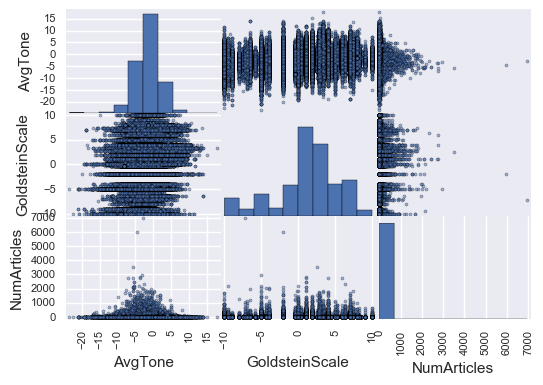

In [17]:
plotting.scatter_matrix(df[['AvgTone', 'GoldsteinScale', 'NumArticles']]) 
plt.savefig('analysis1/scatter_matrix.png')

#### Group by countries involved

In [18]:
groupby_othercountry = df.groupby('OtherCountry')
groupby_othercountry_agg = groupby_othercountry.agg({'NumArticles':sum, 'AvgTone':sum})
groupby_othercountry_agg_sorted = groupby_othercountry_agg.sort(columns='AvgTone')
groupby_othercountry_agg_sorted_head = groupby_othercountry_agg_sorted.head(5)
groupby_othercountry_agg_sorted_head

/Users/tanya/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,NumArticles,AvgTone
OtherCountry,,
MX,716906,-151951.234068
UK,623160,-105558.525824
CH,480969,-73110.153436
CA,441509,-51300.912880
IN,108058,-24514.113462


### Comparative study of US relations with other countries

In [19]:
#top_other_countries = list(groupby_othercountry_agg_sorted_head.reset_index()['OtherCountry'])
top_other_countries = ['UK', 'CA', 'CH', 'MX', 'IN']
df_only_top_other_countries = df.loc[df['OtherCountry'].isin(top_other_countries)]
df_only_top_other_countries.head()

,SQLDATE,ActionGeo_CountryCode,Actor1Geo_CountryCode,Actor1Code,Actor1Name,Actor1Type1Code,Actor1EthnicCode,Actor1Religion1Code,Actor2Geo_CountryCode,Actor2Code,...,AvgTone,NumArticles,GoldsteinScale,QuadClass,EventRootCode,IsRootEvent,MonthYear,Year,OtherCountry,QuadClass_Cat
0,2017-01-01,US,NaN,NaN,NaN,NaN,NaN,NaN,CA,CAN,...,-2.799552,1,4.0,1,03,0,201701,2017,CA,1
1,2017-01-01,US,NaN,NaN,NaN,NaN,NaN,NaN,CA,USA,...,-5.400458,8,-9.0,4,18,0,201701,2017,CA,4
2,2017-01-01,US,NaN,NaN,NaN,NaN,NaN,NaN,CA,USA,...,-5.400458,8,-10.0,4,19,0,201701,2017,CA,4
6,2017-01-01,CH,CH,CHN,CHINA,NaN,NaN,NaN,US,USA,...,-0.642766,8,6.4,2,06,1,201701,2017,CH,2
8,2017-01-01,UK,US,CHN,CHINA,NaN,NaN,NaN,UK,USAAGR,...,1.170399,24,3.4,1,05,1,201701,2017,UK,1


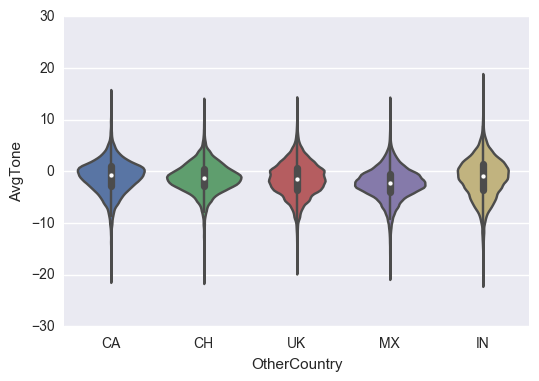

In [20]:
sns.violinplot(x="OtherCountry", y="AvgTone", data=df_only_top_other_countries)
plt.savefig('analysis1/violinplot.png')

#### The cumulative sum of AvgTone gives the real picture of the state of these relationships

/Users/tanya/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


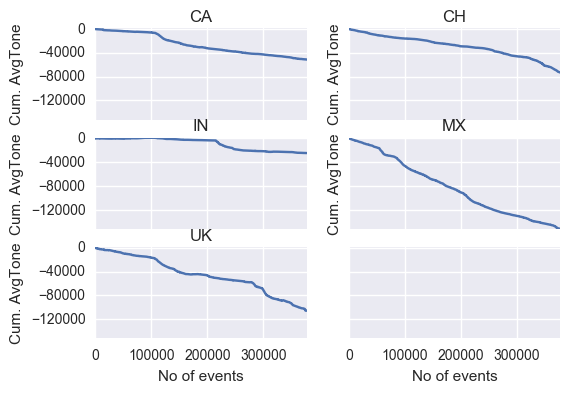

In [21]:
# Set ticks to months
top_only_groupby_othercountry = df_only_top_other_countries.groupby('OtherCountry')
f, axarr = plt.subplots(3,2, sharex=True, sharey=True)
counter = 0
for name, group in top_only_groupby_othercountry:
    group['AvgToneCumSum'] = group['AvgTone'].cumsum()
    row = int(counter / 2)
    col = counter % 2    
    axarr[row][col].plot(group['AvgToneCumSum'])
    axarr[row][col].set_title(name)
    axarr[row][col].set_ylabel('Cum. AvgTone')
    axarr[row][col].xaxis.set_ticks(np.arange(0, 400000, 100000))
    axarr[row][col].yaxis.set_ticks(np.arange(-120000, 20000, 40000))
    counter = counter + 1
axarr[2][0].set_xlabel('No of events')
axarr[2][1].set_xlabel('No of events')

plt.savefig('analysis1/comparitive_decline.png')
